# Download Air Traffic Data and Import Basic Pkgs

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import ipdb

# Load Data

## OD data

In [2]:
# generate an OD matrix from cumulative trip record
# completed by code "OD_batch.py"

In [3]:
year = 2019
quarter = 4

OD = pd.read_csv('./outputs/%i0%i_OD.csv'%(year, quarter), index_col=0)


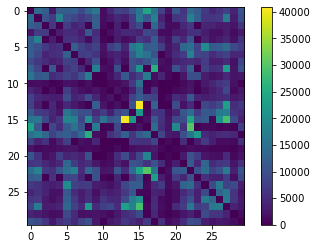

In [4]:
plt.figure()
plt.imshow(OD)
plt.colorbar()

## SLD

In [5]:
# metadata = pd.read_csv('./data/US-APT-Information.csv', index_col=0)
# metadata.head(2)

airport_df = pd.read_csv('./data/airport_core.csv')
airport_df.head(2)

,Airport,lat,lon,state,state_code,city
0,ATL,33.640833,-84.427222,Georgia,GA,Atlanta
1,BOS,42.363611,-71.006111,Massachusetts,MA,Boston


In [6]:
sl_data = pd.read_csv('./data/Smart Location Data Export.csv')
sl_data['GEOID'] = sl_data['GEOID20'] // 10
sl_data['COUNTYID'] = sl_data['GEOID20'] // 1e7

In [7]:
sl_data.head(2)

,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,...,VMT_tot_min,VMT_tot_max,VMT_tot_avg,GHG_per_worker,Annual_GHG,SLC_score,Shape_Length,Shape_Area,GEOID,COUNTYID
0,1,481130078254,481130078254,48,113,7825,4,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,11.442995,82.636303,25.659327,24.499297,6369.817221,77.450956,3110.36082,297836.0831,48113007825,48113.0
1,2,481130078252,481130078252,48,113,7825,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,11.442995,82.636303,25.659327,23.580987,6131.056669,78.898635,3519.46911,484945.1466,48113007825,48113.0


In [42]:
# may spend around 2 minutes
us_tract = gpd.GeoDataFrame(columns=gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_06_tract.zip').columns)
for i in ['01','04','05','06','08','09',10,11,12,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56]:
    try:
        tract = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_%i_tract.zip'%i)
    except:
        tract = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_%s_tract.zip'%i)
    us_tract = us_tract.append(tract)

us_tract.index = range(us_tract.shape[0])


In [71]:
def add_att(df, att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    df[att] = ''
    for i in df.index:
        geoid = int(df.loc[i, 'GEOID'])
        if type_ == 'sum':
            df.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].sum()
        elif type_ == 'mean':
            df.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].mean()
        elif type_ == 'same':
#             ipdb.set_trace()
            df.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].iloc[0]
    return df
    

In [51]:
att_lst = [
    'CSA', 'CSA_Name', 'CBSA', 'CBSA_Name', 'AutoOwn0', 'AutoOwn1', 'AutoOwn2p',\
    'TotEmp', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', 'D1B', 'D1C', 'D3A', 'D4A', 'D4B050', 'D4C', 'D4D', \
    'D5AR', 'D5AE', 'NatWalkInd', 'TotPop'
]

type_lst = [
    'same', 'same', 'same', 'same', 'sum', 'sum', 'sum',\
    'sum', 'sum', 'sum', 'sum', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean',\
    'sum', 'sum', 'mean', 'sum'
]

assert(len(att_lst) == len(type_lst))

In [52]:
# may spend around 20~30 minutes
for i in range(len(att_lst)):
    us_tract = add_att(us_tract, att_lst[i], type_lst[i])
    print('Complete', att_lst[i])

Complete CSA
Complete CSA_Name
Complete CBSA
Complete CBSA_Name
Complete AutoOwn0
Complete AutoOwn1
Complete AutoOwn2p
Complete TotEmp
Complete E_LowWageWk
Complete E_MedWageWk
Complete E_HiWageWk
Complete D1B
Complete D1C
Complete D3A
Complete D4A
Complete D4B050
Complete D4C
Complete D4D
Complete D5AR
Complete D5AE
Complete NatWalkInd
Complete TotPop


In [53]:
# may spend around 2 minutes
for i in us_tract.index:
    us_tract.loc[i, 'COUNTYID'] = us_tract.loc[i, 'GEOID'][:5]

att_lst.append('COUNTYID')
att_lst.append('GEOID')
type_lst.append('same')
type_lst.append('same')

In [54]:
us_tract.head(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,TotPop,COUNTYID
0,01,055,010700,01055010700,107,Census Tract 107,G5020,S,87404337,2927199,...,3.610139,-99999.0,0.0,-99999.0,-99999.0,13684,13141,4.166667,3750,01055
1,01,055,001300,01055001300,13,Census Tract 13,G5020,S,5083957,836213,...,16.467295,-99999.0,0.0,-99999.0,-99999.0,54622,43352,8.666667,2807,01055


In [91]:
from shapely.ops import unary_union

def get_county_data():
    # 新建一个表格，找出各个county的数据（通过合并各个county的tract来实现）
    county_lst = us_tract['COUNTYID'].drop_duplicates()  # datatype: series
    col_ = ['TotPop', 'COUNTYID', 'geometry']
    county_data = gpd.GeoDataFrame(columns=col_, index=range(len(county_lst)))
    
    for i in range(len(county_lst)):
        this_county_id = county_lst.iloc[i]
        this_county = us_tract[us_tract['COUNTYID']==this_county_id]
        polygons = this_county['geometry']
        boundary = gpd.GeoSeries(unary_union(polygons))
        
        county_data.loc[i, 'geometry'] = boundary.values
        county_data.loc[i, 'COUNTYID'] = this_county_id
        county_data.loc[i, 'TotPop'] = this_county['TotPop'].sum()
        
    return county_data

In [92]:
# may spend around 1.5 minutes
us_county = get_county_data()

In [93]:
us_county.head(2)

,TotPop,COUNTYID,geometry
0,102939,01055,"POLYGON ((-85.98820 33.87924, -85.99497 33.879..."
1,20298,01107,"POLYGON ((-88.33929 33.00300, -88.33845 33.010..."


In [94]:
def add_att_county(df, att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    df[att] = ''
    for i in df.index:
        geoid = int(df.loc[i, 'COUNTYID'])
        if type_ == 'sum':
            df.loc[i, att] = sl_data.loc[sl_data['COUNTYID']==geoid, att].sum()
        elif type_ == 'mean':
            df.loc[i, att] = sl_data.loc[sl_data['COUNTYID']==geoid, att].mean()
        elif type_ == 'same':
#             ipdb.set_trace()
            df.loc[i, att] = sl_data.loc[sl_data['COUNTYID']==geoid, att].iloc[0]
    return df
    

In [95]:
for i in range(len(att_lst)-2):  # except for COUNTYID and GEOID
    us_county = add_att_county(us_county, att_lst[i], type_lst[i])
    print('Complete', att_lst[i])

Complete CSA
Complete CSA_Name
Complete CBSA
Complete CBSA_Name
Complete AutoOwn0
Complete AutoOwn1
Complete AutoOwn2p
Complete TotEmp
Complete E_LowWageWk
Complete E_MedWageWk
Complete E_HiWageWk
Complete D1B
Complete D1C
Complete D3A
Complete D4A
Complete D4B050
Complete D4C
Complete D4D
Complete D5AR
Complete D5AE
Complete NatWalkInd
Complete TotPop


In [104]:
us_county.head(2)

,TotPop,COUNTYID,geometry,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,...,D1B,D1C,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd
0,102939,01055,"POLYGON ((-85.98820 33.87924, -85.99497 33.879...",NaN,NaN,23460.0,"Gadsden, AL",2441,12009,24327,...,1.529579,0.791391,10.617419,-99999.0,0.0,-99999.0,-99999.0,1028152,900253,6.238956
1,20298,01107,"POLYGON ((-88.33929 33.00300, -88.33845 33.010...",NaN,NaN,46220.0,"Tuscaloosa, AL",731,2298,4501,...,0.058953,0.009858,1.801684,-99999.0,0.0,-99999.0,-99999.0,36617,40661,4.54386


In [99]:
def add_att_state(df, att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    if att=='STATEFP':
        return df
    df[att] = ''
    for i in df.index:
        geoid = int(df.loc[i, 'STATEFP'])
        if type_ == 'sum':
            df.loc[i, att] = sl_data.loc[sl_data['STATEFP']==geoid, att].sum()
        elif type_ == 'mean':
            df.loc[i, att] = sl_data.loc[sl_data['STATEFP']==geoid, att].mean()
        elif type_ == 'same':
#             ipdb.set_trace()
            df.loc[i, att] = sl_data.loc[sl_data['STATEFP']==geoid, att].iloc[0]
    return df
    

In [100]:
from shapely.ops import unary_union

def get_state_data():
    # 新建一个表格，找出各个state的数据（通过合并各个state的tract来实现）
    state_lst = us_tract['STATEFP'].drop_duplicates()  # datatype: series
    col_ = ['TotPop', 'STATEFP', 'geometry']
    state_data = gpd.GeoDataFrame(columns=col_, index=range(len(state_lst)))
    
    for i in range(len(state_lst)):
        this_state_id = state_lst.iloc[i]
        this_state = us_tract[us_tract['STATEFP']==this_state_id]
        polygons = this_state['geometry']
        boundary = gpd.GeoSeries(unary_union(polygons))
        
        state_data.loc[i, 'geometry'] = boundary.values
        state_data.loc[i, 'STATEFP'] = this_state_id
        state_data.loc[i, 'TotPop'] = this_state['TotPop'].sum()
        
    return state_data

In [101]:
us_state = get_state_data()

In [108]:
for i in range(len(att_lst)-2):  # except for COUNTYID and GEOID
    us_state = add_att_state(us_state, att_lst[i], type_lst[i])
    print('Complete', att_lst[i])

Complete CSA
Complete CSA_Name
Complete CBSA
Complete CBSA_Name
Complete AutoOwn0
Complete AutoOwn1
Complete AutoOwn2p
Complete TotEmp
Complete E_LowWageWk
Complete E_MedWageWk
Complete E_HiWageWk
Complete D1B
Complete D1C
Complete D3A
Complete D4A
Complete D4B050
Complete D4C
Complete D4D
Complete D5AR
Complete D5AE
Complete NatWalkInd
Complete TotPop


In [109]:
us_state.head(2)

,TotPop,STATEFP,geometry,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,...,D1B,D1C,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd
0,4864680,01,"POLYGON ((-88.06069 30.14442, -88.06919 30.146...",142.0,"Birmingham-Hoover-Talladega, AL",13820.0,"Birmingham-Hoover, AL",115360,602858,1142051,...,1.884375,0.834243,9.141649,-85691.056591,0.0,-85891.734212,-85890.980826,80015382,58768634,6.8312
1,6946685,04,"POLYGON ((-112.62491 31.82102, -112.62548 31.8...",429.0,"Phoenix-Mesa, AZ",38060.0,"Phoenix-Mesa-Chandler, AZ",160011,912818,1451471,...,7.143349,2.241679,17.872108,-45943.701668,0.026742,-39583.881192,-39569.96112,285956773,225138695,10.104197


In [125]:
# us_tract.fillna(0).to_file('./data/us_tract.shp', driver='ESRI Shapefile')
# us_county.fillna(0).to_file('./data/us_county.shp', driver='ESRI Shapefile')
# us_state.fillna(0).to_file('./data/us_state.shp', driver='ESRI Shapefile')

/var/folders/6v/_k68w5jd2fjdr7stnfl1_q_c0000gn/T/ipykernel_7240/1310443233.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  us_tract.fillna(0).to_file('./outputs/us_tract.shp', driver='ESRI Shapefile')
/var/folders/6v/_k68w5jd2fjdr7stnfl1_q_c0000gn/T/ipykernel_7240/1310443233.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  us_county.fillna(0).to_file('./outputs/us_county.shp', driver='ESRI Shapefile')
/var/folders/6v/_k68w5jd2fjdr7stnfl1_q_c0000gn/T/ipykernel_7240/1310443233.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  us_state.fillna(0).to_file('./outputs/us_state.shp', driver='ESRI Shapefile')
